# Installing Libraries

In [101]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from IPython.display import display
import matplotlib.pyplot as plt 
from matplotlib import pyplot
import cv2
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.backend import log, epsilon
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import glob
import pandas as pd
import os
from sklearn.preprocessing import LabelEncoder

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

# PART A

## Q1. Understand data

### A. Import and read ‘images.npy’

In [243]:
!pwd

/Users/kashmkj/Documents/Learning Resources/GreatLearning/CV


In [244]:
file_path = 'images.npy'
image_np = np.load(file_path, allow_pickle = True)

#### Getting to Know the data

In [245]:
print("shape of image_np is: " , image_np.shape)
print("DataType of image_np is: " , image_np.dtype)

shape of image_np is:  (409, 2)
DataType of image_np is:  object


In [246]:
# Let's check what does image_np[0] contains
image_np[0]

array([array([[[42, 37, 34],
               [56, 51, 48],
               [71, 66, 63],
               ...,
               [23, 33, 34],
               [26, 36, 37],
               [28, 38, 39]],

              [[40, 35, 32],
               [51, 46, 43],
               [64, 59, 56],
               ...,
               [27, 36, 35],
               [24, 33, 32],
               [26, 35, 34]],

              [[43, 38, 35],
               [51, 46, 43],
               [61, 56, 53],
               ...,
               [28, 30, 27],
               [33, 35, 32],
               [35, 37, 34]],

              ...,

              [[56, 47, 40],
               [57, 48, 41],
               [61, 52, 45],
               ...,
               [67, 48, 42],
               [55, 35, 28],
               [60, 40, 33]],

              [[53, 44, 37],
               [54, 45, 38],
               [57, 48, 41],
               ...,
               [59, 40, 34],
               [60, 40, 33],
               [54, 34, 27]],



In [247]:
image_np[0][0]

array([[[42, 37, 34],
        [56, 51, 48],
        [71, 66, 63],
        ...,
        [23, 33, 34],
        [26, 36, 37],
        [28, 38, 39]],

       [[40, 35, 32],
        [51, 46, 43],
        [64, 59, 56],
        ...,
        [27, 36, 35],
        [24, 33, 32],
        [26, 35, 34]],

       [[43, 38, 35],
        [51, 46, 43],
        [61, 56, 53],
        ...,
        [28, 30, 27],
        [33, 35, 32],
        [35, 37, 34]],

       ...,

       [[56, 47, 40],
        [57, 48, 41],
        [61, 52, 45],
        ...,
        [67, 48, 42],
        [55, 35, 28],
        [60, 40, 33]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [60, 40, 33],
        [54, 34, 27]],

       [[53, 44, 37],
        [54, 45, 38],
        [57, 48, 41],
        ...,
        [59, 40, 34],
        [70, 50, 43],
        [64, 44, 37]]], dtype=uint8)

In [248]:
image_np[0][0].shape

(333, 650, 3)

In [249]:
image_np[408][1]

[{'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.3201219512195122, 'y': 0.2839756592292089},
   {'x': 0.4009146341463415, 'y': 0.4198782961460446}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.4557926829268293, 'y': 0.38742393509127787},
   {'x': 0.5442073170731707, 'y': 0.5618661257606491}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.6707317073170732, 'y': 0.38336713995943206},
   {'x': 0.7134146341463414, 'y': 0.4746450304259635}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.16615853658536586, 'y': 0.4665314401622718},
   {'x': 0.22560975609756098, 'y': 0.563894523326572}],
  'imageWidth': 656,
  'imageHeight': 493},
 {'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.07164634146341463, 'y': 0.539553752535497},
   {'x': 0.11280487804878049, 'y': 0.5862068965517241}],
  'imageWidth': 656,
  'imageHeight

- Hence, image_np[x][0] contains x image matrix of size 333*650 with 3 channels , i.e., RGB
- image_np[x][1] contains description about objects (faces) in the image in the form of list-dictionary.

### B. Split the data into Features(X) & labels(Y). Unify shape of all the images

In [253]:
X = image_np[:,0]
Y = image_np[:,1]
print(X.shape, Y.shape)

(409,) (409,)


In [254]:
# Creating a user-defined function to show the image passed as np array argument
def show_image(image):
    im1 = Image.fromarray(image)
    display(im1)

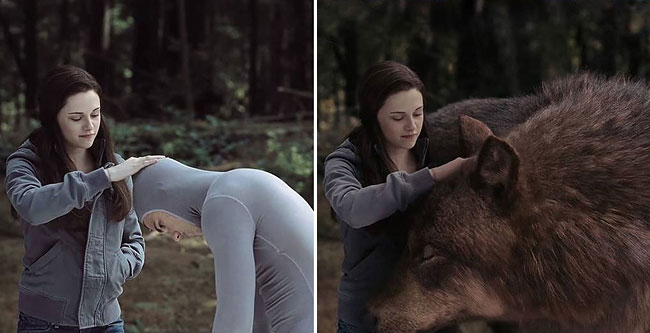

In [255]:
show_image(X[0])

In [256]:
IMAGE_WIDTH = 128
IMAGE_HEIGHT = 128
masks = np.zeros((int(image_np.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X_training = np.zeros((int(image_np.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(image_np.shape[0]):
    img = image_np[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X_training[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in image_np[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [257]:
X_training.shape

(409, 128, 128, 3)

In [258]:
masks.shape

(409, 128, 128)

### C. Split the data into train and test[400:9].

In [259]:
X_train = X_training[:400,:,:,:]
X_test = X_training[400:409,:,:,:]

In [260]:
X_train.shape, X_test.shape

((400, 128, 128, 3), (9, 128, 128, 3))

In [261]:
masks_train = masks[:400,:,:]
masks_test = masks[400:409,:,:]
masks_train.shape, masks_test.shape

((400, 128, 128), (9, 128, 128))

#### D. Select random image from the train data and display original image and masked image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


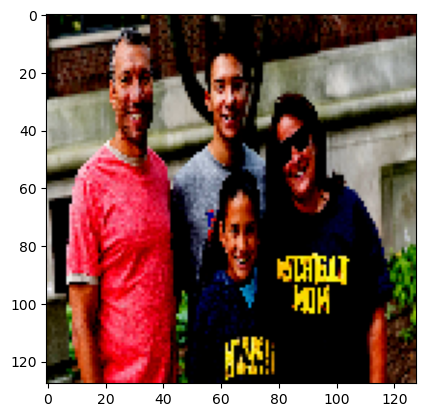

In [262]:
pyplot.imshow(X_train[87])

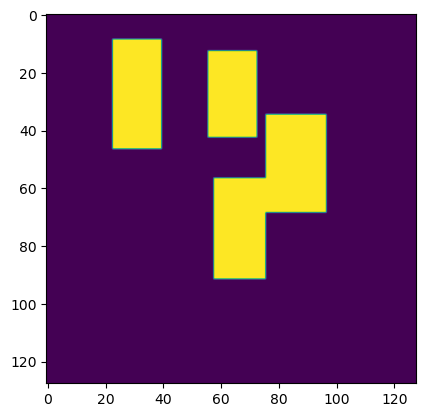

In [263]:
pyplot.imshow(masks[87])

## Q2. Model building

### A. Design a face mask detection model

In [264]:
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
ALPHA = 1

In [265]:
model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")
model.summary()

Model: "mobilenet_1.00_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 32)        864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 64, 64, 32)       128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 64, 64, 32)        0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)       288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 64, 64, 32)       128       
 ation)                                         

In [266]:
def create_model(trainable=False):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable
        
    block00 = model.layers[0].input
    block01 = model.get_layer("conv_pw_1_relu").output
    block02 = model.get_layer("conv_pw_2_relu").output
    block03 = model.get_layer("conv_pw_3_relu").output
    block05 = model.get_layer("conv_pw_5_relu").output
    block11 = model.get_layer("conv_pw_11_relu").output
    block13 = model.get_layer("conv_pw_13_relu").output

    decoderBlock = Concatenate()([UpSampling2D()(block13), block11])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block05])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block03])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block01])
    decoderBlock = Concatenate()([UpSampling2D()(decoderBlock), block00])

    decoderBlock = Conv2D(1, kernel_size=1, activation="sigmoid")(decoderBlock)
    decoderBlock = Reshape((IMAGE_HEIGHT, IMAGE_WIDTH))(decoderBlock)

    return Model(inputs=model.input, outputs=decoderBlock) 


In [267]:
model = create_model()

model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_2[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']         

### B. Design your own Dice Coefficient and Loss function

In [268]:
def dice_coefficient(y_actual, y_pred):
    numerator = 2 * tf.reduce_sum(y_actual * y_pred)
    denominator = tf.reduce_sum(y_actual + y_pred)

    return numerator / (denominator + tf.keras.backend.epsilon())

In [269]:
def loss(y_actual, y_pred):
    return binary_crossentropy(y_actual, y_pred) - log(dice_coefficient(y_actual, y_pred) + epsilon())

### C,D. Train and tune the model as required, Evaluate and share insight

In [270]:
model = create_model(False)
model.summary()
optimizer = tf.keras.optimizers.Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, amsgrad=False)
model.compile(optimizer = optimizer, loss=loss, metrics=[dice_coefficient])

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 32)   128         ['conv1[0][0]']                  
                                                                                                  
 conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['conv1_bn[0][0]']         

In [271]:
checkpoint = ModelCheckpoint("model-{loss:.2f}.h5", monitor="loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="min", save_freq=1)
stop = EarlyStopping(monitor="loss", patience=5, mode="min")
reduce_lr = ReduceLROnPlateau(monitor="loss", factor=0.2, patience=1, min_lr=1e-6, verbose=1, mode="min")

In [272]:
model.fit(X_train, masks_train, epochs = 4, verbose=1, batch_size=3, callbacks=[checkpoint,reduce_lr,stop])

Epoch 1/4

Epoch 1: loss improved from inf to 2.22360, saving model to model-2.22.h5
  1/134 [..............................] - ETA: 4:18 - loss: 2.2236 - dice_coefficient: 0.2181
Epoch 1: loss improved from 2.22360 to 2.19040, saving model to model-2.19.h5
  2/134 [..............................] - ETA: 39s - loss: 2.1904 - dice_coefficient: 0.2281 
Epoch 1: loss did not improve from 2.19040
  3/134 [..............................] - ETA: 29s - loss: 2.8421 - dice_coefficient: 0.1602
Epoch 1: loss did not improve from 2.19040
  4/134 [..............................] - ETA: 24s - loss: 3.0240 - dice_coefficient: 0.1333
Epoch 1: loss did not improve from 2.19040
  5/134 [>.............................] - ETA: 22s - loss: 2.8238 - dice_coefficient: 0.1499
Epoch 1: loss did not improve from 2.19040
  6/134 [>.............................] - ETA: 22s - loss: 2.6300 - dice_coefficient: 0.1883
Epoch 1: loss did not improve from 2.19040
  7/134 [>.............................] - ETA: 20s - lo

- Even with 4-5 Epochs we were able to get a decent Dice Coff which is above 50% which is still good to test on the test image.¶
- I tried with image_size (228, 228), (32, 32) and (128, 128). The best results were given for 128,128, i.e., better performance and fast training as well
- I tried Learning rate as 1e-3, and 1e-4. The time difference was negligble and 1e-4 provided better results

## Q3. Test the model predictions on the test image: ‘image with index 3 in the test data’ and visualise the predicted masks on the faces in the image

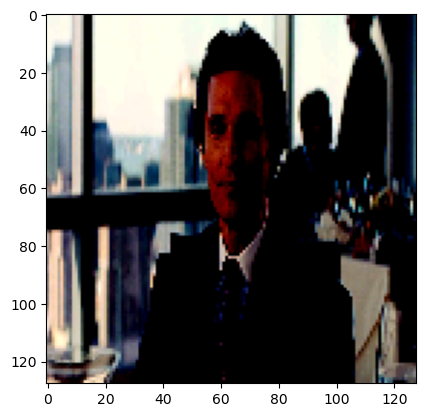

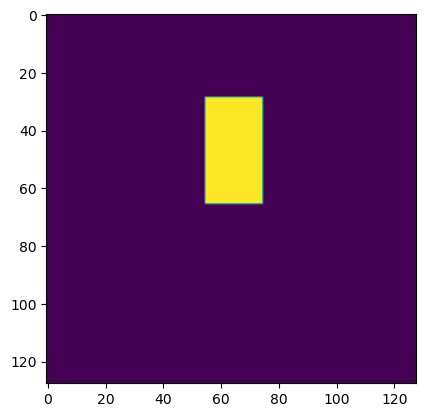

In [291]:
pyplot.imshow(X_test[3])
plt.show()
pyplot.imshow(masks_test[3])
plt.show()

1/1 [==============================] - 0s 109ms/step


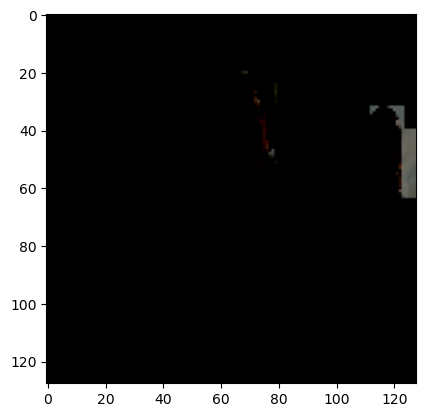

In [292]:
image = cv2.resize(X_train[3], dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)

pred_mask = cv2.resize(1.0*(model.predict(x=np.array([image]))[0] > 0.2), (IMAGE_WIDTH,IMAGE_HEIGHT))
image2 = image
image2[:,:,0] = pred_mask*image[:,:,0]
image2[:,:,1] = pred_mask*image[:,:,1]
image2[:,:,2] = pred_mask*image[:,:,2]

out_image = image2

plt.imshow(out_image)

# Part B

## Q1. Read/import images from folder ‘training_images’.

In [2]:
file_path_training_image= 'training_images/*.*'

In [3]:
training_images = []
for file in glob.glob(file_path_training_image):
  image_read = cv2.imread(file)
  training_images.append(image_read)

In [4]:
training_images[0].shape

(600, 600, 3)

## Q2. Write a loop which will iterate through all the images in the ‘training_images’ folder and detect the faces present on all the images

In [5]:
def image_resize(image):
    print(image.shape)
    scale_percent = 40
    width = int(image.shape[1]*scale_percent/100)
    height = int(image.shape[0]*scale_percent/100)
    dim = (width, height)
    resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
    print(resized.shape)
    return resized

In [27]:
%matplotlib inline
def detect_faces(image_resized):
    face_classifier = cv2.CascadeClassifier('../../../../../kashmkj/micromamba/envs/tensorflow_gl/share/opencv4/haarcascades/haarcascade_frontalface_default.xml')
    gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY)
    faces = face_classifier.detectMultiScale(gray, 1.0485258, 6)
    '''When no faces detected, face_classifier returns and empty tuple'''
    if faces == ():
        print("No faces found")
    '''We iterate through our faces array and draw a rectangle over each face in faces'''
    print(len(faces))
    for (x,y,w,h) in faces:
        cv2.rectangle(image_resized, (x,y), (x+w,y+h), (127,0,255), 2)
        plt.imshow(image_resized)
        # plt.show() I am commenting this otherwise, it will show images of all faces in one go and this results in heavy processing usage
        # cv2.waitKey(0)
    cv2.destroyAllWindows()
    return faces

(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)


/var/folders/y3/sj4jd8d52hgf1dwssqb4kb580000gn/T/ipykernel_91919/4045269602.py:7: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if faces == ():


(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
No faces found
0
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
No faces found
0
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
No faces found
0
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
No faces found
0
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
1
(600, 600, 3)
(240, 240, 3)
No faces found
0
(600, 600, 3)
(240, 240, 3)
1
(600, 600

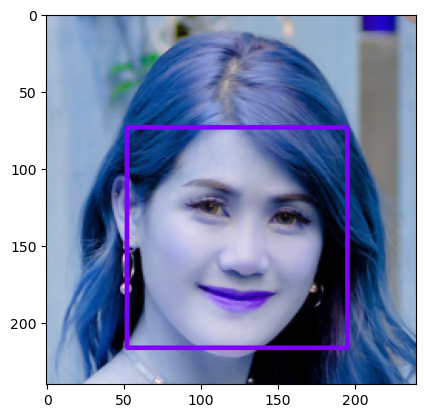

In [28]:
faces_images = []
for image in range(len(training_images)):
    image_resized = image_resize(training_images[image])
    faces_images.append(detect_faces(image_resized))

In [36]:
len(faces_images), faces_images[48], len(faces_images[48])

(1091,
 array([[ 25,  20, 192, 192],
        [ 83,  97, 115, 115]], dtype=int32),
 2)

## Q3. From the same loop above, extract metadata of the faces and write into a DataFrame

In [69]:
folder_path = 'training_images/'
image_paths = glob.glob(folder_path + '*.jpg')

# Create an empty DataFrame to store the face metadata
face_data = pd.DataFrame(columns=['x', 'y', 'w', 'h', 'Total_Faces', 'Image_Name'])

for path in image_paths:
    image = cv2.imread(path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    face_classifier = cv2.CascadeClassifier('../../../../../kashmkj/micromamba/envs/tensorflow_gl/share/opencv4/haarcascades/haarcascade_frontalface_default.xml')
    faces = face_classifier.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5, minSize=(30, 30))
    for (x, y, w, h) in faces:
        # Append the face metadata to the DataFrame
        face_data = pd.concat([face_data, pd.DataFrame({'x': [x], 'y': [y], 'w': [w], 'h': [h], 'Total_Faces': [len(faces)], 'Image_Name': [path.replace('training_images/','')]})], ignore_index=True)

# Print the resulting DataFrame
print(face_data)

       x    y    w    h Total_Faces         Image_Name
0     93  140  391  391           1     real_00251.jpg
1     56   78  473  473           1     real_00537.jpg
2    116  151  382  382           1     real_00523.jpg
3     82  135  395  395           1     real_00245.jpg
4    153  211  371  371           1     real_00279.jpg
..   ...  ...  ...  ...         ...                ...
944   92   53  485  485           1     real_00506.jpg
945   57   26  494  494           1     real_00512.jpg
946   80  156  426  426           1     real_00274.jpg
947   74   54  464  464           1  real_01007(1).jpg
948  129  180  362  362           1     real_00248.jpg

[949 rows x 6 columns]


## Q4. Save the output Dataframe in .csv format

In [70]:
# Save the DataFrame to a CSV file
csv_file_output = 'face_metadata.csv'
face_data.to_csv(csv_file_output, index=False)

# PART C

## Q1. Unzip, read and Load data(‘PINS.zip’) into session. [2 Marks]

In [71]:
pins_zip_file = 'PINS.zip'
from zipfile import ZipFile

with ZipFile(pins_zip_file, 'r') as z:
  z.extractall()

## Q2, Q3. Write function to create metadata of the image, Write a loop to iterate through each and every image and create metadata for all the images

In [74]:
class IdentityMetadata():
    def __init__(self, base, name, file):
        print(base, name, file)
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            # Check file extension. Allow only jpg/jpeg' files.
            ext = os.path.splitext(f)[1]
            if ext == '.jpg' or ext == '.jpeg':
                metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('PINS')

PINS pins_mark zuckerberg mark zuckerberg1.jpg
PINS pins_mark zuckerberg mark zuckerberg50.jpg
PINS pins_mark zuckerberg mark zuckerberg44.jpg
PINS pins_mark zuckerberg mark zuckerberg45.jpg
PINS pins_mark zuckerberg mark zuckerberg51.jpg
PINS pins_mark zuckerberg mark zuckerberg0.jpg
PINS pins_mark zuckerberg mark zuckerberg2.jpg
PINS pins_mark zuckerberg mark zuckerberg47.jpg
PINS pins_mark zuckerberg mark zuckerberg53.jpg
PINS pins_mark zuckerberg mark zuckerberg52.jpg
PINS pins_mark zuckerberg mark zuckerberg46.jpg
PINS pins_mark zuckerberg mark zuckerberg3.jpg
PINS pins_mark zuckerberg mark zuckerberg7.jpg
PINS pins_mark zuckerberg mark zuckerberg42.jpg
PINS pins_mark zuckerberg mark zuckerberg56.jpg
PINS pins_mark zuckerberg mark zuckerberg57.jpg
PINS pins_mark zuckerberg mark zuckerberg43.jpg
PINS pins_mark zuckerberg mark zuckerberg6.jpg
PINS pins_mark zuckerberg mark zuckerberg4.jpg
PINS pins_mark zuckerberg mark zuckerberg55.jpg
PINS pins_mark zuckerberg mark zuckerberg41.jpg

In [78]:
metadata[0]

PINS/pins_mark zuckerberg/mark zuckerberg1.jpg

## Q4. Generate Embeddings vectors on the each face in the dataset

In [81]:
def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

In [82]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ZeroPadding2D, Convolution2D, MaxPooling2D, Dropout, Flatten, Activation

def vgg_face():	
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(224,224, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    return model

In [83]:
model = vgg_face()
model.load_weights('vgg_face_weights.h5')

Metal device set to: Apple M2


In [89]:
vgg_face_categoriser = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)
vgg_face_categoriser.input, vgg_face_categoriser.output

(<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'zero_padding2d_input')>,
 <KerasTensor: shape=(None, 2622) dtype=float32 (created by layer 'flatten')>)

In [92]:
# Get embedding vector for first image in the metadata using the pre-trained model
img_path = metadata[0].image_path()
img = load_image(img_path)

# Normalising pixel values from [0-255] to [0-1]: scale RGB values to interval [0,1]
img = (img / 255.).astype(np.float32)
img = cv2.resize(img, dsize = (224,224))
print(img.shape)

# Obtain embedding vector for an image
# Get the embedding vector for the above image using vgg_face_descriptor model and print the shape 
embedding_vector = vgg_face_categoriser.predict(np.expand_dims(img, axis=0))[0]
print(embedding_vector.shape)

(224, 224, 3)
1/1 [==============================] - 0s 21ms/step
(2622,)


In [93]:
embeddings = np.zeros((metadata.shape[0], 2622))
for i, m in enumerate(metadata):
    img_path = metadata[i].image_path()
    img = load_image(img_path)
    img = (img / 255.).astype(np.float32)
    img = cv2.resize(img, dsize = (224,224))
    embedding_vector = vgg_face_categoriser.predict(np.expand_dims(img, axis=0))[0]
    embeddings[i]=embedding_vector

1/1 [==============================] - 0s 12ms/step


## Q5. Build distance metrics for identifying the distance between two similar and dissimilar images

In [95]:
print('Shape of Embeddings :', embeddings.shape)

Shape of Embeddings : (10770, 2622)


In [96]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

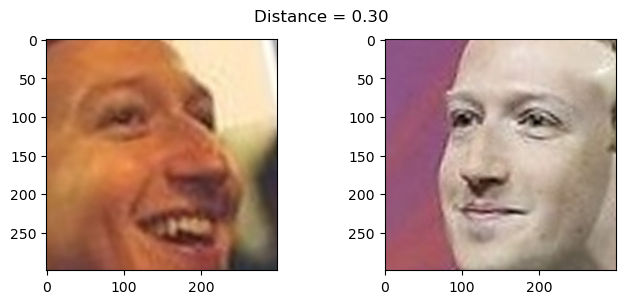

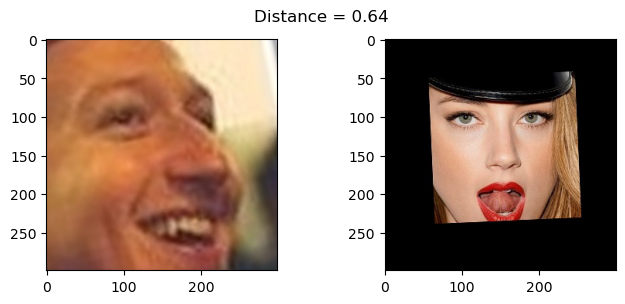

In [97]:
import matplotlib.pyplot as plt

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embeddings[idx1], embeddings[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 180)

## Q6. Use PCA for dimensionality reduction

In [98]:
train_idx = np.arange(metadata.shape[0]) % 9 != 0     
test_idx = np.arange(metadata.shape[0]) % 9 == 0

# one half as train examples of 10 identities
X_train = embeddings[train_idx]

# another half as test examples of 10 identities
X_test = embeddings[test_idx]
targets = np.array([m.name for m in metadata])

#train labels
y_train = targets[train_idx]

#test labels
y_test = targets[test_idx]

print('X_train shape : ({0},{1})'.format(X_train.shape[0], X_train.shape[1]))
print('y_train shape : ({0},)'.format(y_train.shape[0]))
print('X_test shape : ({0},{1})'.format(X_test.shape[0], X_test.shape[1]))
print('y_test shape : ({0},)'.format(y_test.shape[0]))

X_train shape : (9573,2622)
y_train shape : (9573,)
X_test shape : (1197,2622)
y_test shape : (1197,)


In [102]:
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)

In [103]:
print(le.classes_)
y_test_encoded = le.transform(y_test)

['pins_Aaron Paul' 'pins_Alvaro Morte' 'pins_Amanda Crew'
 'pins_Amaury Nolasco' 'pins_Anna Gunn' 'pins_Benedict Cumberbatch'
 'pins_Betsy Brandt' 'pins_Brenton Thwaites' 'pins_Brit Marling'
 'pins_Bryan Cranston' 'pins_Caity Lotz' 'pins_Cameron Monaghan'
 'pins_Chance Perdomo' 'pins_Chris Evans' 'pins_Chris Pratt'
 'pins_Cobie Smulders' 'pins_Danielle Panabaker' 'pins_Dave Franco'
 'pins_Dominic Purcell' 'pins_Dwayne Johnson' 'pins_Emilia Clarke'
 'pins_Emily Bett Rickards' 'pins_Emma Stone' 'pins_Gwyneth Paltrow'
 'pins_Henry Cavil' 'pins_Jason Momoa' 'pins_Jeremy Renner'
 'pins_Jesse Eisenberg' 'pins_Jim Parsons' 'pins_Jon Bernthal'
 'pins_Josh Radnor' 'pins_Kit Harington' 'pins_Krysten Ritter'
 'pins_Kumail Nanjiani' 'pins_Maisie Williams' 'pins_Mark Ruffalo'
 'pins_Martin Starr' 'pins_Melissa benoit' 'pins_Mike Colter'
 'pins_Morena Baccarin' 'pins_Morgan Freeman' 'pins_Natalie Portman'
 'pins_Neil Patrick Harris' 'pins_Paul Rudd' 'pins_Pedro Alonso'
 'pins_Peter Dinklage' 'pins_R

In [104]:
print('y_train_encoded : ', y_train_encoded)
print('y_test_encoded : ', y_test_encoded)

y_train_encoded :  [88 88 88 ... 96 96 96]
y_test_encoded :  [88 88 88 ... 96 96 96]


In [105]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)

In [106]:
X_test_std = scaler.transform(X_test)

In [107]:
print('X_train_std shape : ({0},{1})'.format(X_train_std.shape[0], X_train_std.shape[1]))
print('y_train_encoded shape : ({0},)'.format(y_train_encoded.shape[0]))
print('X_test_std shape : ({0},{1})'.format(X_test_std.shape[0], X_test_std.shape[1]))
print('y_test_encoded shape : ({0},)'.format(y_test_encoded.shape[0]))


X_train_std shape : (9573,2622)
y_train_encoded shape : (9573,)
X_test_std shape : (1197,2622)
y_test_encoded shape : (1197,)


In [108]:
from sklearn.decomposition import PCA

pca = PCA(n_components=128)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)

## Q7. Build an SVM classifier in order to map each image to its right person

In [109]:
from sklearn.svm import SVC

clf = SVC(C=5., gamma=0.001)
clf.fit(X_train_pca, y_train_encoded)

SVC(C=5.0, gamma=0.001)

In [110]:
y_predict = clf.predict(X_test_pca)
print('y_predict : ',y_predict)
print('y_test_encoded : ',y_test_encoded)
y_predict_encoded = le.inverse_transform(y_predict)

y_predict :  [88 88 88 ... 96 96 96]
y_test_encoded :  [88 88 88 ... 96 96 96]


In [111]:
from sklearn.metrics import precision_recall_curve,accuracy_score,f1_score,precision_score,recall_score
accuracy_score(y_test_encoded, y_predict)

0.9532163742690059

## Q8. Import and display the the test images

In [241]:
for i in range(1197):
    print(i, metadata[test_idx][i].image_path())

0 PINS/pins_mark zuckerberg/mark zuckerberg1.jpg
1 PINS/pins_mark zuckerberg/mark zuckerberg52.jpg
2 PINS/pins_mark zuckerberg/mark zuckerberg4.jpg
3 PINS/pins_mark zuckerberg/mark zuckerberg32.jpg
4 PINS/pins_mark zuckerberg/mark zuckerberg34.jpg
5 PINS/pins_mark zuckerberg/mark zuckerberg39.jpg
6 PINS/pins_mark zuckerberg/mark zuckerberg8.jpg
7 PINS/pins_amber heard face/amber heard face101.jpg
8 PINS/pins_amber heard face/amber heard face102.jpg
9 PINS/pins_amber heard face/amber heard face103.jpg
10 PINS/pins_amber heard face/amber heard face138.jpg
11 PINS/pins_amber heard face/amber heard face139.jpg
12 PINS/pins_amber heard face/amber heard face44.jpg
13 PINS/pins_amber heard face/amber heard face46.jpg
14 PINS/pins_amber heard face/amber heard face80.jpg
15 PINS/pins_amber heard face/amber heard face83.jpg
16 PINS/pins_amber heard face/amber heard face82.jpg
17 PINS/pins_amber heard face/amber heard face142.jpg
18 PINS/pins_amber heard face/amber heard face145.jpg
19 PINS/pins_

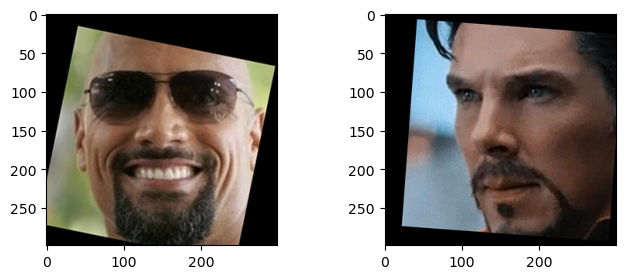

In [242]:
def show_test_images(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_test_images(9108, 6966) # Multiplied the test_image found in the cell just above by 9

## Q9. Use the trained SVM model to predict the face on both test images

## Q9. Use the trained SVM model to predict the face on both test images

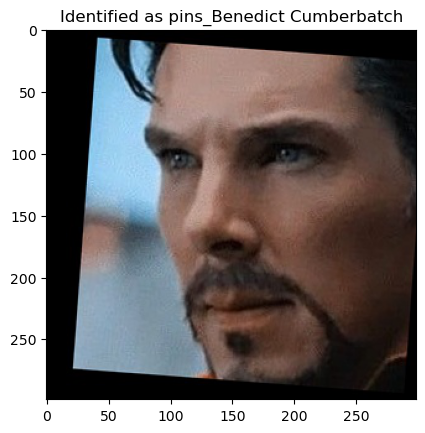

In [240]:
example_idx = 774

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

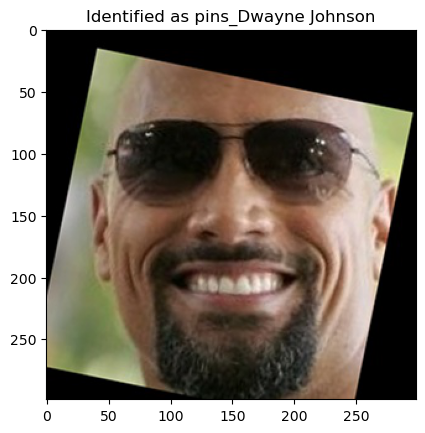

In [215]:
example_idx = 1012

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = y_predict[example_idx]
example_identity =  y_predict_encoded[example_idx]

plt.imshow(example_image)
plt.title(f'Identified as {example_identity}');

# The End